## 네이버 영화평을 이용한 감정 분석

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
from tensorflow.python.keras.preprocessing.text import Tokenizer
import codecs
%matplotlib inline

print(tf.__version__)
tf.enable_eager_execution()

1.13.1


In [2]:
def read_data(filename):
    with open(filename, 'r', encoding='utf8') as f:
        result = [line.split('\t') for line in f.read().splitlines()]
        result = result[1:]   # header 제외
    return result

In [8]:
from konlpy.tag import Twitter

twitter = Twitter()
def getNounAdjective(text):
    stems = []
    tagged = twitter.pos(text, stem=True)
    for i in range(0, len(tagged)):
        if (tagged[i][1] == 'Noun' or tagged[i][1] == 'Adjective'):
            stems.append(tagged[i][0])
    return " ".join(stems)        # join(list): list -> 문자열 (tokenizer하려고)

# "오늘 금요일이네요" -> tagged: "(오늘, Noun), (금요일, Noun), (이다, Verb)" -> stems: list
# -> join: "오늘 금요일"

C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [14]:
twitter.pos('오늘은 금요일 날씨가 흐리네 장마철인가 내일은 주말이네요^^')

[('오늘', 'Noun'),
 ('은', 'Josa'),
 ('금요일', 'Noun'),
 ('날씨', 'Noun'),
 ('가', 'Josa'),
 ('흐리네', 'Verb'),
 ('장마철', 'Noun'),
 ('인가', 'Josa'),
 ('내일', 'Noun'),
 ('은', 'Josa'),
 ('주말', 'Noun'),
 ('이네', 'Josa'),
 ('요', 'Noun'),
 ('^^', 'Punctuation')]

In [15]:
twitter.pos('모두가 자신은 뭔가를 할 수 있을 거라 믿지만 형태나 의미를 느끼지 못하는 뭔가를 늘어놓지마 입만 벌리면 터지는 쓰레기를 주워담지 못해 돈은 많고 할릴ㄹ없는 아이들이 모인ㄷ채 슈비두비비부ㅜㅂ부둡둡ㅂ')

[('모두', 'Noun'),
 ('가', 'Josa'),
 ('자신', 'Noun'),
 ('은', 'Josa'),
 ('뭔가', 'Noun'),
 ('를', 'Josa'),
 ('할', 'Verb'),
 ('수', 'Noun'),
 ('있을', 'Adjective'),
 ('거', 'Noun'),
 ('라', 'Josa'),
 ('믿지만', 'Verb'),
 ('형태', 'Noun'),
 ('나', 'Josa'),
 ('의미', 'Noun'),
 ('를', 'Josa'),
 ('느끼지', 'Verb'),
 ('못', 'VerbPrefix'),
 ('하는', 'Verb'),
 ('뭔가', 'Noun'),
 ('를', 'Josa'),
 ('늘어놓지마', 'Verb'),
 ('입', 'Noun'),
 ('만', 'Josa'),
 ('벌리면', 'Verb'),
 ('터지는', 'Verb'),
 ('쓰레기', 'Noun'),
 ('를', 'Josa'),
 ('주워', 'Verb'),
 ('담지', 'Verb'),
 ('못', 'VerbPrefix'),
 ('해', 'Verb'),
 ('돈', 'Noun'),
 ('은', 'Josa'),
 ('많고', 'Adjective'),
 ('할릴', 'Noun'),
 ('ㄹ', 'KoreanParticle'),
 ('없는', 'Adjective'),
 ('아이', 'Noun'),
 ('들', 'Suffix'),
 ('이', 'Josa'),
 ('모인', 'Verb'),
 ('ㄷ', 'KoreanParticle'),
 ('채', 'Noun'),
 ('슈비', 'Noun'),
 ('두', 'Determiner'),
 ('비비', 'Noun'),
 ('부', 'Noun'),
 ('ㅜㅂ', 'KoreanParticle'),
 ('부', 'Noun'),
 ('둡', 'Verb'),
 ('둡', 'Verb'),
 ('ㅂ', 'KoreanParticle')]

In [18]:
twitter.pos('모두가 자신은 뭔가를 할 수 있을 거라 믿지만 형태나 의미를 느끼지 못하는 뭔가를 늘어놓지마 입만 벌리면 터지는 쓰레기를 주워담지 못해 돈은 많고 할릴ㄹ없는 아이들이 모인ㄷ채 슈비두비비부ㅜㅂ부둡둡ㅂ', stem=True)
# stem=True: 기본형. 할 -> 하다, 느끼지 -> 느끼다

[('모두', 'Noun'),
 ('가', 'Josa'),
 ('자신', 'Noun'),
 ('은', 'Josa'),
 ('뭔가', 'Noun'),
 ('를', 'Josa'),
 ('하다', 'Verb'),
 ('수', 'Noun'),
 ('있다', 'Adjective'),
 ('거', 'Noun'),
 ('라', 'Josa'),
 ('믿다', 'Verb'),
 ('형태', 'Noun'),
 ('나', 'Josa'),
 ('의미', 'Noun'),
 ('를', 'Josa'),
 ('느끼다', 'Verb'),
 ('못', 'VerbPrefix'),
 ('하다', 'Verb'),
 ('뭔가', 'Noun'),
 ('를', 'Josa'),
 ('늘어놓다', 'Verb'),
 ('입', 'Noun'),
 ('만', 'Josa'),
 ('벌리다', 'Verb'),
 ('터지다', 'Verb'),
 ('쓰레기', 'Noun'),
 ('를', 'Josa'),
 ('줍다', 'Verb'),
 ('담다', 'Verb'),
 ('못', 'VerbPrefix'),
 ('하다', 'Verb'),
 ('돈', 'Noun'),
 ('은', 'Josa'),
 ('많다', 'Adjective'),
 ('할릴', 'Noun'),
 ('ㄹ', 'KoreanParticle'),
 ('없다', 'Adjective'),
 ('아이', 'Noun'),
 ('들', 'Suffix'),
 ('이', 'Josa'),
 ('모이다', 'Verb'),
 ('ㄷ', 'KoreanParticle'),
 ('채', 'Noun'),
 ('슈비', 'Noun'),
 ('두', 'Determiner'),
 ('비비', 'Noun'),
 ('부', 'Noun'),
 ('ㅜㅂ', 'KoreanParticle'),
 ('부', 'Noun'),
 ('두다', 'Verb'),
 ('두다', 'Verb'),
 ('ㅂ', 'KoreanParticle')]

In [3]:
train_tmp = read_data('./data/ratings_train.txt')
test_tmp = read_data('./data/ratings_test.txt')

In [13]:
train_tmp[200]  # [id, 평, 긍정부정]

['4038387', 'TV용 건담 시리즈 중에서 아직까지도 최고봉', '1']

In [29]:
def kor_movie():
    # 데이터 구조: ID | 리뷰데이터 | 감성라벨
    # 필요없는 id 제외. 학습용.
    train_x = []
    train_y = []
    for i in range(len(train_tmp)):
        train_x.append(getNounAdjective(train_tmp[i][1]))      # 리뷰 데이터
        train_y.append(int(train_tmp[i][2])) # 라벨
        
    # 테스트용.
    test_x = []
    test_y = []
    for i in range(len(test_tmp)):
        test_x.append(getNounAdjective(test_tmp[i][1]))
        test_y.append(int(test_tmp[i][2]))
    
    return (train_x, train_y), (test_x, test_y)

In [30]:
max_num_words = 1000   # 사람들이 많이 쓰는 1000개 단어만 추출해서 분석하려고

print('...전처리...')
(x_train, y_train), (x_test, y_test) = kor_movie()

...전처리...


In [31]:
print(x_train[0:10])

['더빙 진짜 짜증나다 목소리', '흠 포스터 보고 초딩 영화 줄 오버 연기 가볍다', '무재 밓었 다그 래서 추천', '교도소 이야기 구먼 솔직하다 재미 없다 평점 조정', '몬페 의 익살스럽다 연기 영화 스파이더맨 커스틴 던스트 이쁘다', '막 걸음 마 세 초등학교 학년 생인 영화 반개 아깝다 움', '원작 긴장감 제대로', '별 반개 아깝다 욕 이응경 길용우 생활 년 정말 발 해도 그것 납치 감금 반복 반복 드라마 가족 없다 연기 사람 네', '액션 없다 재미 있다 몇 안되다 영화', '왜케 평점 낮다 꽤 볼 데 헐리우드 화려하다 있다']


In [32]:
print(y_train[0:10])

[0, 1, 0, 0, 1, 0, 0, 0, 1, 1]


In [34]:
len(x_train)

150000

In [35]:
len(y_train)

150000

In [36]:
np.mean([len(x) for x in x_train])

21.881766666666667

In [37]:
np.max([len(x) for x in x_train])

197

In [38]:
from collections import Counter
counter = dict(Counter([len(x) for x in x_train]))
counter

{14: 5203,
 26: 2499,
 27: 2521,
 34: 1325,
 31: 1724,
 10: 5539,
 64: 290,
 20: 3812,
 9: 5416,
 24: 3093,
 25: 2805,
 48: 504,
 11: 5672,
 32: 1576,
 35: 1171,
 33: 1433,
 7: 4956,
 80: 251,
 13: 5352,
 22: 3385,
 2: 3522,
 4: 3714,
 40: 764,
 18: 4190,
 16: 4620,
 23: 3160,
 15: 4973,
 51: 455,
 97: 104,
 87: 217,
 36: 1019,
 29: 2098,
 6: 4232,
 17: 4567,
 42: 585,
 104: 54,
 49: 504,
 28: 2261,
 65: 308,
 37: 969,
 8: 5544,
 5: 4635,
 45: 534,
 12: 5525,
 19: 3966,
 63: 322,
 38: 910,
 3: 2495,
 76: 289,
 21: 3642,
 75: 260,
 91: 163,
 0: 2640,
 1: 1509,
 70: 273,
 93: 163,
 47: 510,
 52: 450,
 74: 250,
 62: 318,
 54: 379,
 60: 349,
 83: 229,
 30: 1848,
 68: 285,
 50: 514,
 59: 355,
 39: 788,
 43: 693,
 103: 44,
 46: 543,
 55: 345,
 94: 135,
 72: 273,
 90: 168,
 56: 399,
 66: 277,
 79: 241,
 109: 15,
 58: 305,
 81: 232,
 89: 196,
 95: 129,
 41: 688,
 86: 225,
 77: 246,
 57: 342,
 44: 577,
 67: 281,
 61: 325,
 78: 266,
 85: 224,
 53: 428,
 101: 67,
 84: 233,
 88: 213,
 98: 101,
 73

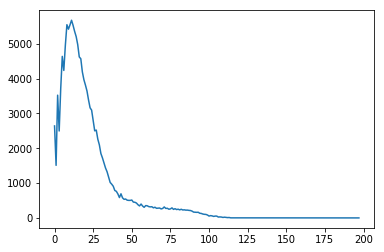

In [40]:
lists = sorted(counter.items()) # sorted by key

x, y = zip(*lists)  # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [41]:
tokenizer = Tokenizer(num_words=max_num_words-1)   # -1: 학습 안된 단어에 '0' 주려고 '0' 자리 남김
tokenizer.fit_on_texts(x_train)

x_train_token = tokenizer.texts_to_sequences(x_train)
x_test_token = tokenizer.texts_to_sequences(x_test)

In [42]:
x_train_token[0:10]

[[294, 7, 151, 441],
 [653, 295, 23, 409, 1, 121, 12, 452],
 [126],
 [66, 123, 33, 2, 13],
 [243, 12, 1, 146],
 [490, 662, 496, 1, 730, 25, 140],
 [120, 195, 203],
 [152, 730, 25, 208, 434, 5, 503, 388, 383, 986, 986, 19, 169, 2, 12, 21, 754],
 [59, 2, 33, 3, 568, 62, 1],
 [13, 111, 348, 50, 248, 445, 3]]

In [43]:
one_word_idx = [i for i in range(len(x_train_token)) if len(x_train_token[i]) < 2]
len(one_word_idx)

23683

In [44]:
one_word_idx

[2,
 15,
 21,
 26,
 27,
 28,
 42,
 54,
 56,
 59,
 69,
 72,
 75,
 79,
 81,
 86,
 87,
 88,
 91,
 92,
 97,
 106,
 107,
 113,
 116,
 124,
 130,
 132,
 134,
 137,
 138,
 140,
 143,
 144,
 145,
 151,
 158,
 159,
 160,
 166,
 169,
 173,
 176,
 179,
 185,
 205,
 207,
 214,
 234,
 238,
 247,
 251,
 277,
 278,
 295,
 307,
 315,
 319,
 324,
 326,
 331,
 338,
 350,
 357,
 379,
 384,
 392,
 398,
 399,
 402,
 404,
 407,
 411,
 412,
 416,
 421,
 422,
 426,
 429,
 438,
 470,
 472,
 477,
 480,
 485,
 487,
 489,
 501,
 513,
 521,
 524,
 526,
 529,
 549,
 559,
 563,
 583,
 584,
 590,
 593,
 595,
 615,
 618,
 638,
 659,
 663,
 666,
 668,
 684,
 695,
 698,
 714,
 719,
 721,
 723,
 724,
 728,
 731,
 734,
 736,
 737,
 751,
 765,
 780,
 787,
 788,
 793,
 795,
 799,
 800,
 804,
 805,
 806,
 822,
 841,
 862,
 863,
 865,
 876,
 899,
 906,
 911,
 923,
 924,
 925,
 926,
 927,
 932,
 933,
 949,
 960,
 965,
 971,
 972,
 976,
 979,
 995,
 996,
 1005,
 1007,
 1009,
 1011,
 1017,
 1031,
 1032,
 1036,
 1037,
 1042,
 104

In [45]:
x_train_token = [text for i, text in enumerate(x_train_token) if i not in one_word_idx]
x_train_token

[[294, 7, 151, 441],
 [653, 295, 23, 409, 1, 121, 12, 452],
 [66, 123, 33, 2, 13],
 [243, 12, 1, 146],
 [490, 662, 496, 1, 730, 25, 140],
 [120, 195, 203],
 [152, 730, 25, 208, 434, 5, 503, 388, 383, 986, 986, 19, 169, 2, 12, 21, 754],
 [59, 2, 33, 3, 568, 62, 1],
 [13, 111, 348, 50, 248, 445, 3],
 [196, 7],
 [497, 595, 414, 537],
 [575, 27, 512, 12, 649],
 [867, 4, 606, 37, 21, 14],
 [589, 7, 207, 1, 104, 209, 695, 20, 68, 16, 20],
 [21, 883, 422, 883, 987, 35, 14],
 [824, 14, 77, 18, 314, 331, 33],
 [52, 5, 296],
 [184, 220, 725, 220, 227, 11, 61],
 [215, 868, 3, 74, 35, 1, 227, 11],
 [38, 40, 8, 1, 135, 66, 3, 33, 3, 52, 50, 2, 67, 383, 67],
 [227, 533, 1, 11, 241, 859],
 [440, 4, 558, 40],
 [43, 2, 44, 87, 44],
 [3, 70, 296, 10],
 [48, 103, 342, 249, 12, 5, 4, 54, 19],
 [41, 322, 42, 25],
 [6, 10, 18, 111],
 [157, 28, 53, 53],
 [9, 19, 93, 15],
 [142, 941, 729],
 [12, 401],
 [120, 290, 30],
 [295, 3, 269, 252],
 [9, 1, 18, 301],
 [538, 106, 1],
 [34, 2, 101, 2, 49, 2, 54, 152, 1, 2

In [46]:
y_train_token = [text for i, text in enumerate(y_train) if i not in one_word_idx]
y_train_token

[0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,


In [60]:
a = [1, 2, 3, 4, 5, 6, 7, 1, 2, 3]
# enumerate: index와 값 리턴
b = [text for i, text in enumerate(a) if i % 2 == 0 ] # i: index
print(b)

[1, 3, 5, 7, 2]


In [61]:
len(x_train_token)

126317

In [62]:
len(y_train_token)

126317

In [64]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
reverse_word_map

{1: '영화',
 2: '없다',
 3: '있다',
 4: '좋다',
 5: '정말',
 6: '재밌다',
 7: '진짜',
 8: '같다',
 9: '이',
 10: '점',
 11: '아니다',
 12: '연기',
 13: '평점',
 14: '것',
 15: '최고',
 16: '스토리',
 17: '생각',
 18: '왜',
 19: '드라마',
 20: '감동',
 21: '사람',
 22: '이렇다',
 23: '보고',
 24: '말',
 25: '아깝다',
 26: '더',
 27: '때',
 28: '내',
 29: '배우',
 30: '재미있다',
 31: '거',
 32: '감독',
 33: '재미',
 34: '내용',
 35: '그냥',
 36: '뭐',
 37: '그',
 38: '재미없다',
 39: '좀',
 40: '지루하다',
 41: '쓰레기',
 42: '시간',
 43: '수',
 44: '그렇다',
 45: '나',
 46: '작품',
 47: '사랑',
 48: '다시',
 49: '하나',
 50: '볼',
 51: '마지막',
 52: '이건',
 53: '이다',
 54: '완전',
 55: '정도',
 56: '많다',
 57: '처음',
 58: '장면',
 59: '액션',
 60: '주인공',
 61: '걸',
 62: '안되다',
 63: '최악',
 64: '지금',
 65: '돈',
 66: '이야기',
 67: '별로',
 68: '임',
 69: '느낌',
 70: '연출',
 71: '개',
 72: '끝',
 73: '명작',
 74: '듯',
 75: '좋아하다',
 76: '역시',
 77: '이해',
 78: '괜찮다',
 79: '이영화',
 80: '안',
 81: '또',
 82: '여자',
 83: '때문',
 84: '아름답다',
 85: '난',
 86: '중',
 87: '꼭',
 88: '편',
 89: '보기',
 90: '기억',
 91: '결말',
 92: '마음',


In [67]:
maxlen = 40

x_train_pad = pad_sequences(x_train_token, maxlen=maxlen, padding='post')
x_test_pad = pad_sequences(x_test_token, maxlen=maxlen, padding='post')

x_train_pad[0:10]

array([[294,   7, 151, 441,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [653, 295,  23, 409,   1, 121,  12, 452,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [ 66, 123,  33,   2,  13,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [243,  12,   1, 146,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [490, 662, 496,   1, 730,  25, 140,   0,   0,   0,   0,   0, 

In [66]:
x_train_pad.shape

(126317, 40)

In [68]:
one_hot = np.eye(max_num_words)

In [69]:
model = Sequential()
model.add(layers.Embedding(input_dim=max_num_words, output_dim=max_num_words,
                           input_length=maxlen,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))

Instructions for updating:
Colocations handled automatically by placer.


In [71]:
matrix1 = model(x_train_pad[0:10])
matrix1

<tf.Tensor: id=20, shape=(10, 40, 1000), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        

In [77]:
matrix1[0]

<tf.Tensor: id=10122, shape=(40, 1000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [72]:
model.add(tf.keras.layers.LSTM(units=128))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 1000)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               578048    
Total params: 1,578,048
Trainable params: 1,578,048
Non-trainable params: 0
_________________________________________________________________


In [73]:
matrix2 = model(x_train_pad[0:10])
matrix2

<tf.Tensor: id=5242, shape=(10, 128), dtype=float32, numpy=
array([[-0.02625698, -0.02620302,  0.02632388, ..., -0.00232983,
         0.01055153, -0.03465445],
       [-0.02638975, -0.02616674,  0.02639886, ..., -0.00228833,
         0.01061546, -0.03469206],
       [-0.02626428, -0.02619221,  0.02632419, ..., -0.00232169,
         0.01056016, -0.03465327],
       ...,
       [-0.02633349, -0.02618631,  0.02637879, ..., -0.00229679,
         0.010587  , -0.03466669],
       [-0.02635443, -0.026174  ,  0.02637162, ..., -0.00230346,
         0.01058096, -0.03467358],
       [-0.02623801, -0.02619815,  0.02630611, ..., -0.00235015,
         0.01054365, -0.03465074]], dtype=float32)>

In [74]:
num_classes = 2

In [75]:
model.add(layers.Dense(units=num_classes, activation=tf.nn.softmax))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 1000)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               578048    
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 1,578,306
Trainable params: 1,578,306
Non-trainable params: 0
_________________________________________________________________


In [76]:
matrix3 = model(x_train_pad[0:10])
matrix3

<tf.Tensor: id=10117, shape=(10, 2), dtype=float32, numpy=
array([[0.48837575, 0.5116243 ],
       [0.48836085, 0.5116391 ],
       [0.48837188, 0.51162815],
       [0.48837045, 0.5116295 ],
       [0.48836654, 0.51163346],
       [0.488375  , 0.511625  ],
       [0.4882719 , 0.51172817],
       [0.48836857, 0.51163137],
       [0.48836514, 0.5116348 ],
       [0.48837999, 0.51162004]], dtype=float32)>

In [78]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 1000)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               578048    
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 1,578,306
Trainable params: 1,578,306
Non-trainable params: 0
_________________________________________________________________


In [79]:
y_train_token

[0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,


In [81]:
y_train_pad = np.eye(2)[y_train_token]
y_train_pad

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [86]:
y_test_pad = np.eye(2)[y_test]
y_test_pad

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [87]:
batch_size = 1000

model.fit(x_train_pad, y_train_pad, batch_size=batch_size,
          epochs=5, validation_data=(x_test_pad, y_test_pad))

Train on 126317 samples, validate on 50000 samples
Instructions for updating:
Use tf.cast instead.


C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
126317/126317 [==============================] - 567s 4ms/sample - loss: 0.5997 - acc: 0.6227 - val_loss: 0.4485 - val_acc: 0.7748
Epoch 2/5
126317/126317 [==============================] - 379s 3ms/sample - loss: 0.4039 - acc: 0.8152 - val_loss: 0.4296 - val_acc: 0.7889
Epoch 3/5
126317/126317 [==============================] - 378s 3ms/sample - loss: 0.3928 - acc: 0.8201 - val_loss: 0.4190 - val_acc: 0.7994
Epoch 4/5
126317/126317 [==============================] - 388s 3ms/sample - loss: 0.3810 - acc: 0.8255 - val_loss: 0.4219 - val_acc: 0.8020
Epoch 5/5
126317/126317 [==============================] - 381s 3ms/sample - loss: 0.3750 - acc: 0.8289 - val_loss: 0.4146 - val_acc: 0.7968


In [88]:
my_test_data = [
    "너무 지루했습니다. 한 시간이 일년처럼 느껴졌습니다.",
    "옆 사람 통화 소리에 영화에 집중이 않됨.",
    "오랜만에 본 감동적인 영화였다."
]

In [89]:
test_data_list = []
for my_data in my_test_data:
    text = getNounAdjective(my_data)
    test_data_list.append(text)

In [90]:
test_data_list

['지루하다 시간 년', '옆 사람 통화 소리 영화 집중', '만 감동 영화']

In [91]:
my_test_data_token = tokenizer.texts_to_sequences(test_data_list)
my_test_data_token

[[40, 42, 434], [21, 276, 1, 345], [129, 20, 1]]

In [92]:
my_test_data_pad = pad_sequences(my_test_data_token, maxlen=maxlen, padding='post')
my_test_data_pad

array([[ 40,  42, 434,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [ 21, 276,   1, 345,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [129,  20,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]])

In [93]:
predict = model.predict(my_test_data_pad)
predict

array([[0.9586698 , 0.04133015],
       [0.47686473, 0.52313536],
       [0.02488421, 0.9751158 ]], dtype=float32)

In [94]:
predict_num = np.argmax(predict, axis=1)
predict_num

array([0, 1, 1], dtype=int64)

In [95]:
predict_str=['긍정' if pre == 1 else '부정' for pre in predict_num]
predict_str

['부정', '긍정', '긍정']

In [96]:
for i in range(len(my_test_data)):
    print('test sentence:', my_test_data[i], '\t(predict:', predict_str[i], ')')

test sentence: 너무 지루했습니다. 한 시간이 일년처럼 느껴졌습니다. 	(predict: 부정 )
test sentence: 옆 사람 통화 소리에 영화에 집중이 않됨. 	(predict: 긍정 )
test sentence: 오랜만에 본 감동적인 영화였다. 	(predict: 긍정 )
